In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from res.plot_lib import plot_data, plot_data_np, plot_model, set_default
set_default()

C:\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load MNIST dataset
# TRAIN dataset
# Pytorch already has some datasets available for downlaod
train_dataset = datasets.MNIST('../data', train=True, download=True, 
                # transforms that we want to apply when iterating the dataset
                   transform=transforms.ToTensor())

# The datasoar will iterate through the dataset and load the data in memory
train_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=64, shuffle=True)

# TEST dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.ToTensor()),
                    batch_size=1000, shuffle=True)

In [3]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Let's define our AE for denoising

# define the NN architecture
class AE_Denoiser(nn.Module):
    def __init__(self, latent_size = 64):
        super(AE_Denoiser, self).__init__()
        
        self.latent_size = latent_size
        
        ## encoder ##
        # x.size() = bs, 1, 7, 7 -> bs, latent_size
        self.Encoder = nn.Sequential(   nn.Conv2d(1, 64, 3, stride = 2, padding=1), #64x4x4
                                        nn.ReLU(),
                                        nn.Conv2d(64, self.latent_size, 4, stride = 1, padding=0), #64x1x1
                                        nn.ReLU(), 
                                        nn.Flatten())  #latent_size
        
        ## decoder ##
        # x.size() = bs, latent_size, 1, 1 -> bs, 1, 28, 28
        self.Decoder = nn.Sequential(nn.ConvTranspose2d( self.latent_size, 64, 4, 1, 0), #4x4  (W - 1)S -2P + (K - 1) + 1
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 64, 32, 3, 2, 1), #7x7
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 32, 16, 4, 2, 1), #14x14
                                    nn.ReLU(),
                                    nn.ConvTranspose2d( 16, 1, 4, 2, 1), #28x28
                                    nn.Sigmoid())


    def forward(self, x):
        ## encode ##
        latent = self.Encoder(x)  # compressed representation
        
        ## decode ##
        x = self.Decoder(latent.view(x.size(0),self.latent_size,1,1))
        
        return x, latent

    
ae = AE_Denoiser().to(device)
print(ae)

AE_Denoiser(
  (Encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (Decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)


In [5]:
# define Optimizer and Loss
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

# as loss lets use MSE
mse_loss = nn.MSELoss()

In [6]:
# TRAIN!!!

ae.train()

for epoch in range(3):
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data = data.to(device) #bs,1,28,28
        
        # reduce input size
        small_data = nn.functional.interpolate(data, size=(7,7))
        
        optimizer.zero_grad()
        output, latent = ae(small_data)
        # loss between the output of AE and original data
        loss = mse_loss(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    torch.save(ae.state_dict(), "./res/super_res_ae.pth")

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.208383
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.064212
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.037253
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.035485
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.031902
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.030932
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.028228
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.033011
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.027522
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.026043
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.026941
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.024250
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.025945
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.026197
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.026408


In [7]:
# TEST
image, target = next(iter(test_loader)) # load one batch
image = image.to(device)
small_image = nn.functional.interpolate(image, size=(7,7))

ae.eval()
with torch.no_grad():
    big_out, latent = ae(small_image)

(-0.5, 241.5, 31.5, -0.5)

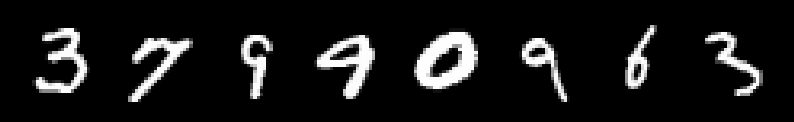

In [9]:
to_pil = transforms.ToPILImage()

image_grid = torchvision.utils.make_grid(image[:8])
plt.imshow(to_pil(image_grid))
plt.axis("off")

(-0.5, 73.5, 10.5, -0.5)

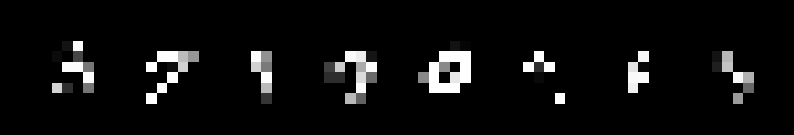

In [10]:
image_grid = torchvision.utils.make_grid(small_image[:8])
plt.imshow(to_pil(image_grid))
plt.axis("off")

(-0.5, 241.5, 31.5, -0.5)

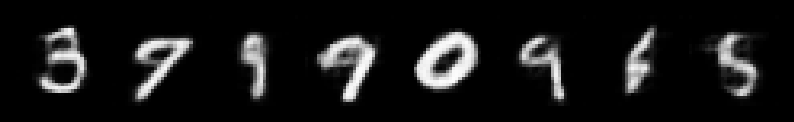

In [11]:
image_grid = torchvision.utils.make_grid(big_out[:8])
plt.imshow(to_pil(image_grid))
plt.axis("off")